In [ ]:
!pip install datasets
!pip install transformers
!pip install bertopic
!sudo apt-get install swig
!sudo pip install jamspell
!wget https://github.com/bakwc/JamSpell-models/raw/master/en.tar.gz
!tar -xvf en.tar.gz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 77.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-whe

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime

import re

import jamspell

from transformers import AutoConfig
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DistilBertForSequenceClassification

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

import nltk
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from collections import defaultdict
from collections import Counter

import altair as alt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Cargamos los datos a analizar
blizzardDf = pd.read_csv('blizzardf.csv')

In [ ]:
blizzardDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23056 entries, 0 to 23055
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  23056 non-null  int64 
 1   id          23056 non-null  int64 
 2   date        23056 non-null  object
 3   username    23056 non-null  object
 4   content     23056 non-null  object
 5   location    14225 non-null  object
 6   retweets    23056 non-null  int64 
 7   likes       23056 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 1.4+ MB


In [ ]:
# Removemos los tweets duplicados
blizzardDf = blizzardDf.drop_duplicates(subset='content')
len(blizzardDf)

22540

In [ ]:
corrector = jamspell.TSpellCorrector()
corrector.LoadLangModel('en.bin')
punct = ''.join([i for i in string.punctuation if i not in [',','?','!','.']])

def light_clean(x):
  # Removemos las url.
  x = re.sub(r"http\S+", ' ', x)
  # Removemos las palabras que empiezan por @.
  x = re.sub(r'@[\w]+', '', x)
  # Signos de puntuacion menos. 
  x = x.translate(str.maketrans('', '', punct))
  x = x.replace('#', '')
  # Spell check
  x = corrector.FixFragment(x)
  return x

In [ ]:
# Aplicamos la funcion de limpieza de datos.
blizzardDf['corpus'] = blizzardDf['content'].apply(light_clean)

In [ ]:
# Codificamos la fecha en el formato apropiado
blizzardDf[['date', 'hour']] = blizzardDf.date.str.split(" ", expand=True)
blizzardDf['date'] = pd.to_datetime(blizzardDf['date'], format="%Y-%m-%d")

In [ ]:
# Modelo a utilizar
MODEL = f"siberett/roberta-sentiment-analysis-finetune"

In [ ]:
# Iniciamos el tokenizador
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/280 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [ ]:
# Iniciamos el modelo.
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
import operator
from scipy.special import softmax

def polarity_predict(example):
  # vectorizamos el texto
  encoded_text = tokenizer(example, return_tensors='pt')
  # aplicamos el modelo
  output = model(**encoded_text)
  # Cogemos los scores de las labels
  scores = output[0][0].detach().numpy()
  # Normalizamos los scores
  scores = softmax(scores)
  # creamos un diccionario con las label y sus scores
  scores_dict = {
      '0' : scores[0],
      '1' : scores[1],
      '2' : scores[2]
  }
  # Obtenemos la label con mayor score
  final_label = max(scores_dict.items(), key=operator.itemgetter(1))[0]
  
  return final_label

In [ ]:
blizzardDf['label'] = blizzardDf['corpus'].apply(polarity_predict)

In [ ]:
# Dividimos el dataset
split_date = datetime(2021,7,20)
preDateDf = blizzardDf.loc[blizzardDf['date'] <= split_date]
postDateDf = blizzardDf.loc[blizzardDf['date'] > split_date]
(len(preDateDf), len(postDateDf))

(6286, 16254)

## Distribucion de los Tweets

In [ ]:
countsPre = preDateDf['label'].value_counts(normalize=True).reset_index()
countsPre.columns = ['target', 'ratio']

alt.Chart(countsPre).mark_bar().encode(
    x=alt.X('target:N', title='Categorías'),
    y=alt.Y('ratio:Q', scale=alt.Scale(domain=(0, 1)), title='Ratio sobre total'),
    tooltip=['target', 'ratio']
).properties(width=600, height=200)

alt.Chart(...)

In [ ]:
countsPost = postDateDf['label'].value_counts(normalize=True).reset_index()
countsPost.columns = ['target', 'ratio']

alt.Chart(countsPost).mark_bar().encode(
    x=alt.X('target:N', title='Categorías'),
    y=alt.Y('ratio:Q', scale=alt.Scale(domain=(0, 1)), title='Ratio sobre total'),
    tooltip=['target', 'ratio']
).properties(width=600, height=200)

alt.Chart(...)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
countsPre.sort_values('target')['ratio']

0    0.574382
1    0.260244
2    0.165375
Name: ratio, dtype: float64

In [ ]:
countsPost.sort_values('target')['ratio']

0    0.574382
1    0.260244
2    0.165375
Name: ratio, dtype: float64

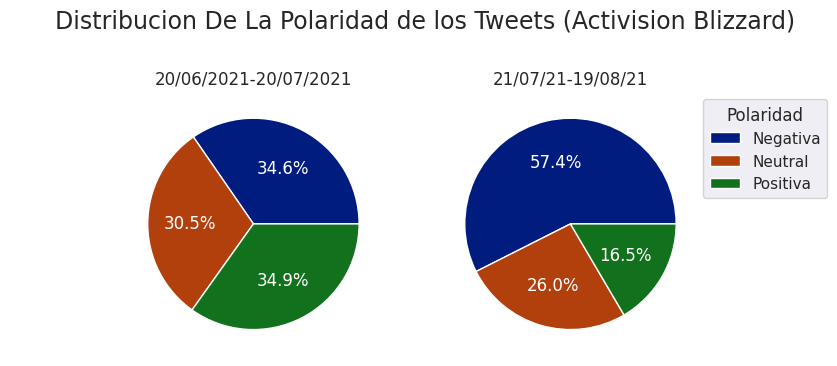

In [ ]:
palette_color = sns.color_palette('dark')

fig, axs = plt.subplots(1, 2)
fig.set_size_inches(7.5, 4.5)
fig.set_dpi(100)

fig.suptitle('      Distribucion De La Polaridad de los Tweets (Activision Blizzard)', fontsize=17)

axs[0].pie(countsPre.sort_values('target')['ratio'], labels=['Negativa', 'Neutral', 'Positiva'], autopct='%1.1f%%', textprops=dict(color="w"), colors=palette_color)
axs[0].set_title("20/06/2021-20/07/2021")

axs[1].pie(countsPost.sort_values('target')['ratio'], labels=['Negativa', 'Neutral', 'Positiva'], autopct='%1.1f%%', textprops=dict(color="w"), colors=palette_color)
axs[1].set_title("21/07/21-19/08/21")

axs[1].legend(title='Polaridad', loc="upper right", bbox_to_anchor=(1, 0, 0.5, 1))

## Numero de palabras por Tweet

In [ ]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

In [ ]:
word_lensPre = [len(line) for line in preDateDf['content'].str.split()]

print('Media de numero de palabras por tweet antes: ', sum(word_lensPre)/len(preDateDf['content']))

print('Media de numero de tweets diarios: ', len(preDateDf['content'])/preDateDf['date'].nunique())

Media de numero de palabras por tweet antes:  21.197581928094177
Media de numero de tweets diarios:  202.7741935483871


In [ ]:
preDateDf['date'].nunique()

31

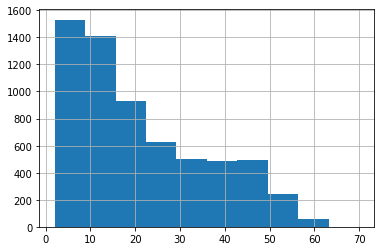

In [ ]:
# Antes del incidente
plot_word_number_histogram(preDateDf['content'])

In [ ]:
word_lensPost = [len(line) for line in postDateDf['content'].str.split()]
print('Media de numero de palabras por tweet despues: ', sum(word_lensPost)/len(postDateDf['content']))
print('Media de numero de tweets diarios: ', len(postDateDf['content'])/postDateDf['date'].nunique())

Media de numero de palabras por tweet despues:  24.632459702227145
Media de numero de tweets diarios:  541.8


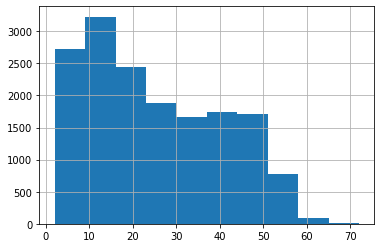

In [ ]:
# Despues del incidende. Se aprecia un aumento en el numero de palabras por tweet
plot_word_number_histogram(postDateDf['content'])

## Distribucion diaria 

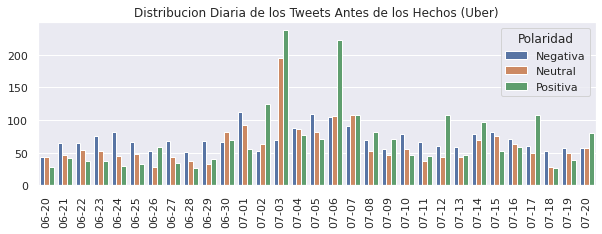

In [ ]:
palette_color = sns.color_palette('dark')

sns.set(rc={"figure.figsize":(10, 3)})
g = sns.countplot(data=preDateDf.sort_values('date'), x="date", hue="label", palette=["C0", "C1", "C2"])
x_dates = preDateDf['date'].dt.strftime('%m-%d').sort_values().unique()
g.set_xticklabels(x_dates)
g.tick_params(axis='x', rotation=90)
g.set_title('Distribucion Diaria de los Tweets Antes de los Hechos (Uber)')
g.set_xlabel('')
g.set_ylabel('')
new_title = 'My title'

plt.legend(title='Polaridad', loc='upper right', labels=['Negativa', 'Neutral', 'Positiva'])

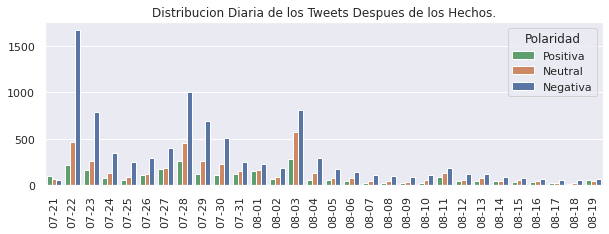

In [ ]:
palette_color = sns.color_palette('dark')

sns.set(rc={"figure.figsize":(10, 3)})
g = sns.countplot(data=postDateDf.sort_values('date'), x="date", hue="label", palette=["C2", "C1", "C0"])
x_dates = postDateDf['date'].dt.strftime('%m-%d').sort_values().unique()
g.set_xticklabels(x_dates)
g.tick_params(axis='x', rotation=90)
g.set_title('Distribucion Diaria de los Tweets Despues de los Hechos.')
g.set_xlabel('')
g.set_ylabel('')
new_title = 'My title'

plt.legend(title='Polaridad', loc='upper right', labels=['Positiva', 'Neutral', 'Negativa'])

## Estadisticas de los tweets


In [ ]:
def clean(x):
  x = x.lower()
  x = ''.join([i for i in x if not i.isdigit()])
  # Removemos palabras con menos de dos caracteres.
  x = ' '.join([w for w in x.split() if len(w)>3])
  return x

In [ ]:
corpusPre = preDateDf.corpus.apply(clean)
corpusPost = postDateDf.corpus.apply(clean)

In [ ]:
# Eliminamos las palabras con menos de 3 caracteres
corpusPre = corpusPre.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
corpusPost = corpusPost.apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
stops = stopwords.words('english') + ['dont', "it's", "don´t", 'since', 'also', 'you', 'still', 'could']

In [ ]:
lemmatizer= WordNetLemmatizer()

textsplit = [line.split() for line in corpusPre]
corpusPre = [[lemmatizer.lemmatize(word) for word in line if word not in stops] for line in textsplit]

corpusPre = [word for i in corpusPre for word in i]

In [ ]:
lemmatizer= WordNetLemmatizer()

textsplit = [line.split() for line in corpusPost]
corpusPost = [[lemmatizer.lemmatize(word) for word in line if word not in stops] for line in textsplit]

corpusPost = [word for i in corpusPost for word in i]

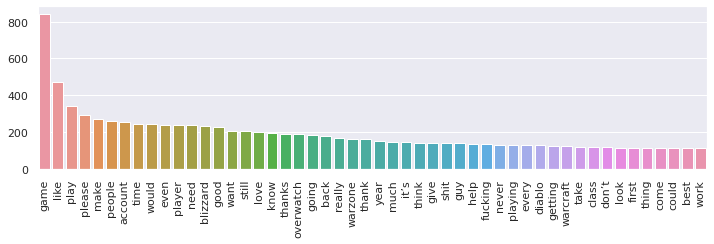

In [ ]:
# 50 palabras mas utilizadas antes de los hechos
counter=Counter(corpusPre)
most=counter.most_common()

x, y= [], []
for word,count in most[:50]:
        x.append(word)
        y.append(count)

sns.set(rc={"figure.figsize":(12, 3)})
g = sns.barplot(x=x,y=y)
g.tick_params(axis='x', rotation=90)

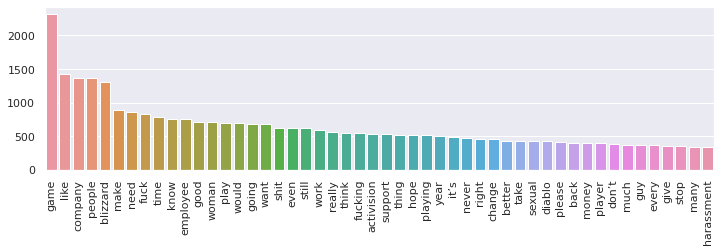

In [ ]:
# 50 palabras mas utilizadas depeus de los hechos
counter=Counter(corpusPost)
most=counter.most_common()

x, y= [], []
for word,count in most[:50]:
        x.append(word)
        y.append(count)

sns.set(rc={"figure.figsize":(12, 3)})
g = sns.barplot(x=x,y=y)
g.tick_params(axis='x', rotation=90)

In [ ]:
# Bigigram antes de los hechos
c_vec = CountVectorizer(stop_words=stops, ngram_range=(2,2))
ngrams_pre = c_vec.fit_transform(preDateDf.corpus)
# count frequency of ngrams
count_values = ngrams_pre.toarray().sum(axis=0)
# list of ngrams
vocab_pre = c_vec.vocabulary_
df_ngram_pre = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab_pre.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [ ]:
df_ngram_pre.head(15)

,frequency,bigram/trigram
0,70,remove sbmm
1,60,good luck
2,47,call duty
3,46,anti cheat
4,43,favorite class
5,39,world warcraft
6,38,play game
7,38,cold war
8,35,please fix
9,35,cross play


In [ ]:
# Bigigram Despues de los hechos
c_vec = CountVectorizer(stop_words=stops, ngram_range=(2,2))
ngrams_post = c_vec.fit_transform(postDateDf.corpus)
# count frequency of ngrams
count_values = ngrams_post.toarray().sum(axis=0)
# list of ngrams
vocab_post = c_vec.vocabulary_
df_ngram_post = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab_post.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})

In [ ]:
df_ngram_post.head(15)

,frequency,bigram/trigram
0,246,sexual harassment
1,194,spit spit
2,181,activision blizzard
3,108,anti cheat
4,97,female employees
5,94,world warcraft
6,89,call duty
7,82,playing games
8,75,good luck
9,75,fuck fuck


##Topic Modeling

In [ ]:
vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words=stops)

In [ ]:
model = BERTopic(vectorizer_model=vectorizer_model, language='english', calculate_probabilities=True, verbose=True)

In [ ]:
temp1 = [i for i in preDateDf['corpus']]
topics, probs = model.fit_transform(temp1)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/197 [00:00<?, ?it/s]

2023-01-07 11:08:09,693 - BERTopic - Transformed documents to Embeddings
2023-01-07 11:08:48,561 - BERTopic - Reduced dimensionality
2023-01-07 11:08:53,209 - BERTopic - Clustered reduced embeddings


In [ ]:
for i in range(15):
  print(f'topic: {i}', model.get_topic(i), '\n')

topic: 0 [('account', 0.03997203723036251), ('hacked', 0.01750788448840949), ('support', 0.016507999857674205), ('help', 0.015923296973308593), ('email', 0.014425966376700627), ('back', 0.014194835693290138), ('activision', 0.012868849944225151), ('account back', 0.011231772478897851), ('get', 0.009501166583154023), ('customer', 0.009152945517416178)] 

topic: 1 [('asshole', 0.023539240894452154), ('asmongold', 0.02281413108174906), ('harassment', 0.016476872447929877), ('aston', 0.016001918539761583), ('calling', 0.012987840773446087), ('blizzard', 0.012777679719578605), ('someone', 0.011220205844937116), ('employee', 0.011149725851839494), ('adam', 0.010475837396110892), ('hes', 0.009911259323979855)] 

topic: 2 [('diablo', 0.08288397858309769), ('resurrected', 0.029774108021192947), ('diablo resurrected', 0.02153528127105175), ('diablo3', 0.0152923327488373), ('physical', 0.014675002359984805), ('diablo2', 0.014639476837968367), ('diablo iii', 0.013716609611729885), ('diablo4', 0.01

In [ ]:
temp2 = [i for i in postDateDf['corpus']]
topics, probs = model.fit_transform(temp2)

Batches:   0%|          | 0/508 [00:00<?, ?it/s]

2023-01-07 11:14:23,319 - BERTopic - Transformed documents to Embeddings
2023-01-07 11:14:39,540 - BERTopic - Reduced dimensionality
2023-01-07 11:15:13,143 - BERTopic - Clustered reduced embeddings


In [ ]:
for i in range(15):
  print(f'topic: {i}', model.get_topic(i), '\n')

topic: 0 [('blizzard', 0.026378522894324956), ('blizzards', 0.005830049093029356), ('blizzard games', 0.005277188358784801), ('people', 0.0048604522101254695), ('company', 0.004394199892866163), ('fuck blizzard', 0.004279519277326281), ('blizzardlawsuit', 0.004012248184770157), ('employees', 0.003927051500893659), ('blizzardwalkout', 0.0036423367055707645), ('games', 0.003612539291774804)] 

topic: 1 [('games', 0.016252802573948736), ('gaming', 0.008982742604336779), ('game', 0.00883238381563355), ('industry', 0.006516388542590719), ('play', 0.0061772180421999535), ('play games', 0.005362682993568598), ('gaming industry', 0.005223447371675489), ('companies', 0.005116471416889434), ('playing', 0.0050291102906910665), ('company', 0.0049077797408712525)] 

topic: 2 [('diablo', 0.04212779015815281), ('beta', 0.01777865768339766), ('resurrected', 0.017331439519281875), ('diablo2resurrected', 0.015557475303116651), ('diablo resurrected', 0.011963487606242605), ('d2r', 0.010762579560462653), 

In [ ]:
preDateDf['label'].value_counts()

2    2191
0    2176
1    1919
Name: label, dtype: int64

In [ ]:
def indice_reputacion(positivos, negativos):
  return (positivos - negativos) / (positivos + negativos)

In [ ]:
print('indice de reputcion antes: ', indice_reputacion(2191, 2176))

indice de reputcion antes:  0.0034348523013510417


In [ ]:
postDateDf['label'].value_counts()

0    9336
1    4230
2    2688
Name: label, dtype: int64

In [ ]:
print('indice de reputcion despues: ', indice_reputacion(2688, 9336))

indice de reputcion despues:  -0.5528942115768463
